In [ ]:
import numpy as np
import os

import matplotlib.pyplot as plt

import keras.layers as layers
import keras.optimizers as optimizers
from keras.models import Model, load_model
from keras import layers
from keras import models
from keras.models import load_model
import keras.backend as K


import ipywidgets
from IPython.display import display, clear_output

In [ ]:
!wget "https://hycms.hanyang.ac.kr/index.php?module=xn_media_content2013&act=dispXn_media_content2013DownloadContent&content_id=6715e0982d404" -O "data.zip"
!unzip  -O cp949 "data.zip" -d "data"

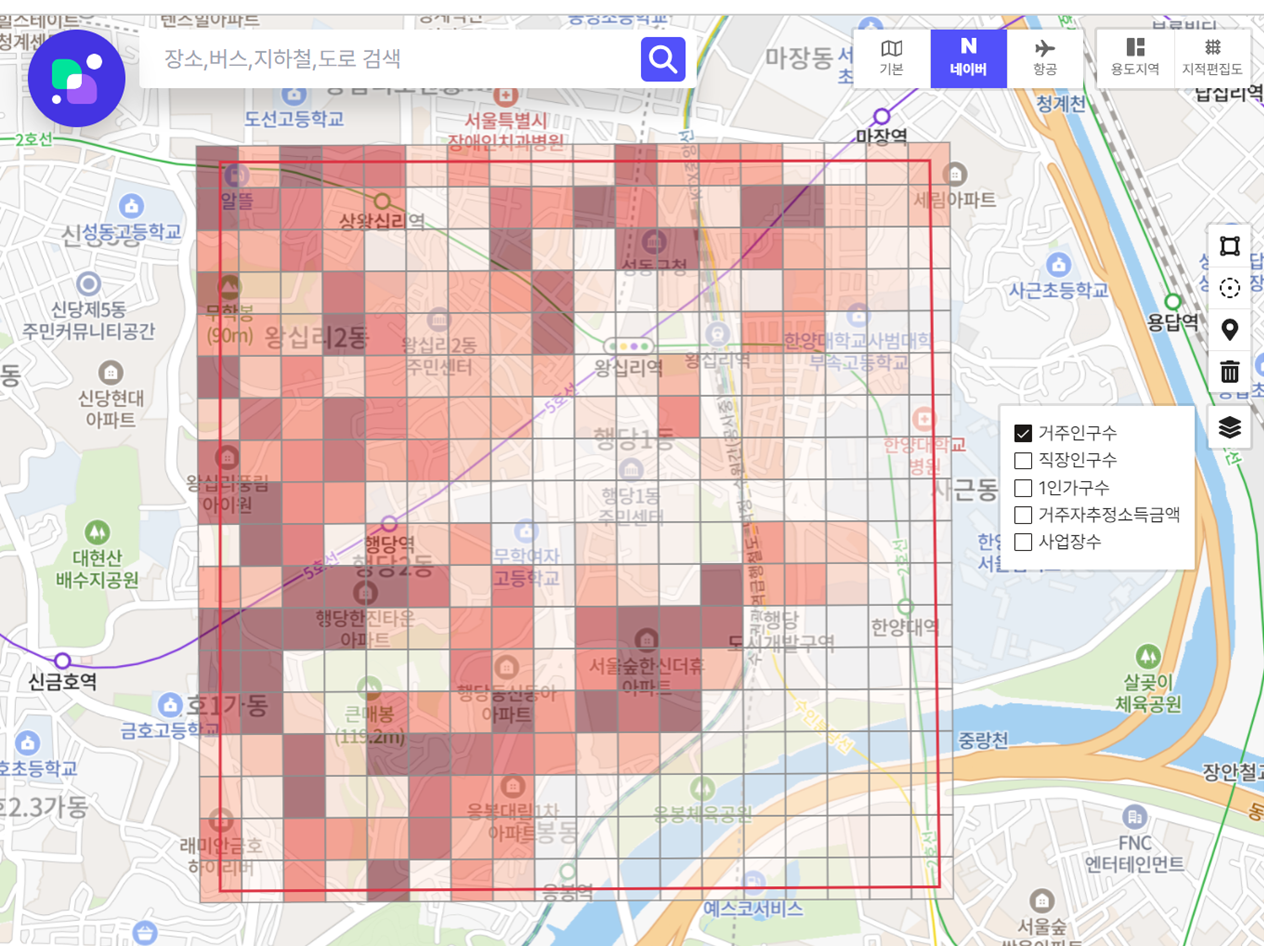

In [ ]:
X = np.load('data/grid_array.npy')
Y = np.load('data/sales.npy')

print(X.shape)
print(Y.shape)

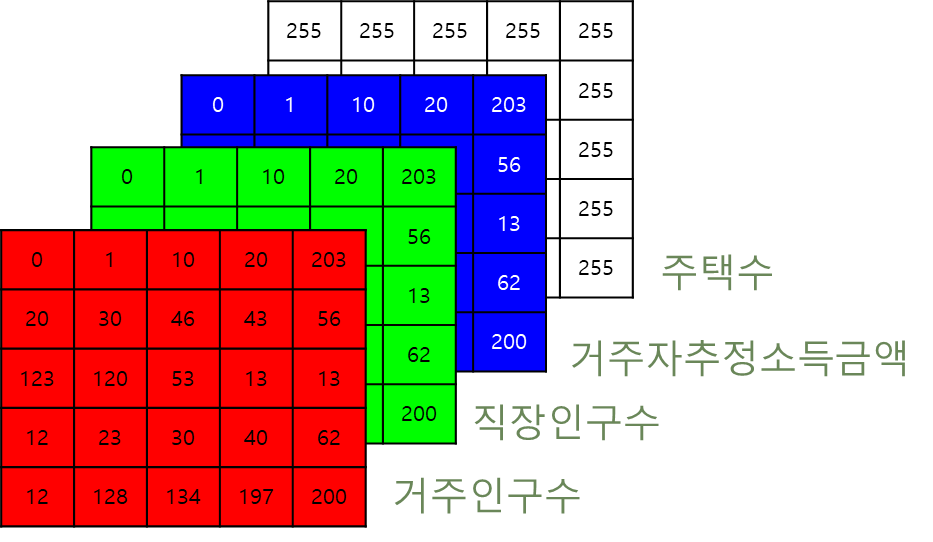

In [ ]:
# Output 위젯 생성
out = ipywidgets.Output()

def display_grid(X, first_idx, last_idx):
    """Displays a grid of values from X based on specified indices.

    Args:
      X: A 4D numpy array.
      first_idx: The index of the first dimension to select.
      last_idx: The index of the last dimension to select.
    """
    if first_idx < 0 or first_idx >= X.shape[0] or last_idx < 0 or last_idx >= X.shape[3]:
        print("Invalid indices.")
        return

    selected_data = X[first_idx, :, :, last_idx]

    with out:
        # 이전 출력 지우기
        clear_output(wait=True)

        print("매출액(월) : " + "{:,.0f}".format(Y[first_idx]) + " 천원")

        # 새 이미지 그리기
        fig, ax = plt.subplots()
        im = ax.imshow(selected_data, cmap='Reds', interpolation='nearest')

        # Add colorbar
        fig.colorbar(im, ax=ax)
        plt.show()

# Create interactive widgets
first_idx_slider = ipywidgets.IntSlider(value=0, min=0, max=X.shape[0] - 1, description='First Index')
last_idx_slider = ipywidgets.IntSlider(value=0, min=0, max=X.shape[3] - 1, description='Last Index')

# Define a function to be called when slider values change
def on_slider_change(change):
    display_grid(X, first_idx_slider.value, last_idx_slider.value)

# Observe slider changes
first_idx_slider.observe(on_slider_change, names='value')
last_idx_slider.observe(on_slider_change, names='value')

# Display widgets and output area
display(ipywidgets.VBox([first_idx_slider, last_idx_slider, out]))

# 초기화면에 그리드 출력
display_grid(X, first_idx_slider.value, last_idx_slider.value)


In [ ]:
# prompt: Y를 학습시키기 전에 학습 가능하게 정규화 해줘

from sklearn.preprocessing import MinMaxScaler

# Y를 정규화합니다.
scaler = MinMaxScaler()
Y_normalized = scaler.fit_transform(Y.reshape(-1, 1))

# Y_normalized를 사용하여 모델을 학습시킵니다.
# ... (모델 학습 코드) ...

# 예측 값을 다시 원래 스케일로 변환합니다.
# Y_predicted_original_scale = scaler.inverse_transform(Y_predicted)

In [ ]:
# prompt: Y_normalized 차트로 표시해줘

plt.figure(figsize=(10, 6))
plt.plot(Y_normalized)
plt.xlabel('Index')
plt.ylabel('Y_normalized')
plt.title('Y_normalized Chart')
plt.grid(True)
plt.show()

In [ ]:
#CNN 네트워크 만들기

inputs = layers.Input(shape=(11, 11, 4))
net = layers.BatchNormalization()(inputs)  # BatchNormalization 추가

net = layers.Conv2D(10, kernel_size=2, padding='same')(net)
net = layers.ReLU()(net)

net = layers.MaxPool2D(pool_size=2)(net)

net = layers.Conv2D(20, kernel_size=2, padding='same')(net)
net = layers.ReLU()(net)

net = layers.MaxPool2D(pool_size=2)(net)

net = layers.Conv2D(10, kernel_size=2, padding='same')(net)
net = layers.ReLU()(net)

net = layers.MaxPool2D(pool_size=2)(net)


net = layers.Flatten()(net)

net = layers.Dense(10, activation='relu')(net)
net = layers.Dropout(0.5)(net)

net = layers.Dense(1, activation='linear')(net)


model = Model(inputs=inputs, outputs=net)
model.compile(
    loss='mse',  #mse, mean_absolute_error
    optimizer='adam',
    metrics=['MAE']
)
model.summary()

In [ ]:
hist = model.fit(X, Y_normalized, epochs=500)

In [ ]:
# prompt: model의 예측 값을 Y_predicted_original_scale = scaler.inverse_transform(Y_predicted) 스케일 변경한 후  실제 y와 비교해줘 비교 결과를 차트로 표현해줘

Y_predicted = model.predict(X)  # 모델 예측 실행
Y_predicted_original_scale = scaler.inverse_transform(Y_predicted)  # 예측 값을 원래 스케일로 변환

# 실제 Y 값과 예측된 Y 값을 비교하는 차트를 생성합니다.
plt.figure(figsize=(10, 6))
plt.plot(Y, label='Actual Y')
plt.plot(Y_predicted_original_scale, label='Predicted Y')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.title('Actual vs Predicted Y')
plt.legend()
plt.show()

In [ ]:
#flatten layer 확인
new_model = Model(model.input,model.layers[11].output) #flatten 결과 비교
new_model.summary()

predict = new_model.predict(X)

In [ ]:
#flatten 값 클러스터링
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3).fit(predict)
result_kmean = np.array(kmeans.labels_)
result_kmean

In [ ]:
#클러스터링 별로 출력해 보기

view_cluster =2


f_cls = np.where(result_kmean == view_cluster)[0]

print("거주인구")
fig = plt.figure(figsize=(15,5))
for idx in range(len(f_cls)) :
  img = X[f_cls[idx],:,:,0]
  img = img.astype('int')
  ax = fig.add_subplot(int((len(f_cls)) / 5+1), 5, idx+1)

  ax.imshow(img, cmap='Reds', vmin=0, vmax=1500)
  ax.set_title("sales : " + "{:,.0f}".format(Y[idx]*1000) + "won")

  ax.axis('off')
plt.show()


print("직장인구")
fig = plt.figure(figsize=(15,5))
for idx in range(len(f_cls)) :

  img = X[f_cls[idx],:,:,1]
  img = img.astype('int')

  ax = fig.add_subplot(int((len(f_cls)) / 5+1), 5, idx+1)

  ax.imshow(img, cmap='Blues', vmin=0, vmax=300)
  ax.set_title("sales : " + "{:,.0f}".format(Y[idx]*300) + "won")

  ax.axis('off')
plt.show()


print("추정소득")
fig = plt.figure(figsize=(15,5))
for idx in range(len(f_cls)) :

  img = X[f_cls[idx],:,:,2]
  img = img.astype('int')

  ax = fig.add_subplot(int((len(f_cls)) / 5+1), 5, idx+1)

  ax.imshow(img, cmap='Greens', vmin=0, vmax=200)
  ax.set_title("sales : " + "{:,.0f}".format(Y[idx]*1000) + "won")

  ax.axis('off')
plt.show()



In [ ]:
!pip install shap

import shap
import numpy as np

In [ ]:


explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)

# Reshape shap_values to 2D
shap_values_reshaped = shap_values.reshape(shap_values.shape[0], -1)
# Reshape X to 2D for consistency
X_reshaped = X.reshape(X.shape[0], -1)

# SHAP 값 시각화 (using reshaped arrays)
shap.summary_plot(shap_values_reshaped, X_reshaped)

In [ ]:
# prompt: 2차원 이미지 처럼 shap 를 표현해줘 실제 값대비 어느 격자의 정보를 더 중요하게 보는지

# ... (your existing code) ...

# SHAP 값 계산 (DeepExplainer 사용)
explainer = shap.DeepExplainer(model, X)
shap_values = explainer.shap_values(X)

# 이미지 형태로 SHAP 값 시각화 (heatmap)
def visualize_shap_image(X, shap_values, image_index):
    """
    특정 이미지에 대한 SHAP 값을 이미지 형태로 시각화합니다.

    Args:
        X: 입력 데이터 (4D numpy array).
        shap_values: SHAP 값 (4D numpy array).
        image_index: 시각화할 이미지의 인덱스.
    """
    image = X[image_index]
    shap_image = shap_values[image_index]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # 원본 이미지 표시
    axes[0].imshow(image[:, :, 0], cmap='gray')
    axes[0].set_title("Original Image")

    # SHAP 값 표시 (heatmap)
    axes[1].imshow(shap_image[:, :, 0], cmap='RdBu', vmin=-abs(shap_image).max(), vmax=abs(shap_image).max())
    axes[1].set_title("SHAP Values (Heatmap)")

    plt.show()

# 특정 이미지에 대한 SHAP 값 시각화
visualize_shap_image(X, shap_values, 0)  # 예시: 첫 번째 이미지에 대한 SHAP 값 시각화

# 여러 이미지에 대한 SHAP 값 시각화
for i in range(5):  # 예시: 첫 번째 5개 이미지에 대한 SHAP 값 시각화
    visualize_shap_image(X, shap_values, i)
